# Data Read-in, QC, & Data merge

In this notebook, the data will be read in from the CellRanger output matrix, The relevent quality measures will be visualized and explored, filtered based  on these measures then the seperate datasets merged together into a single Anndata object which will be saved for loading into the net notebook. A report should also be able to be generated which contains the initial initial stats, QC figures, post-filtering stats. 

## Packages and Read-in 

import necesary packages/modules here followed by reading the 7 datasets as 10x Cellranger matrix files into anndata objects using the scanpy read_10x_mtx function, each dataset and a name as a dicitonary key/value pair, so the initial steps can be done on each serperately easily.



In [7]:
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt

# Modify the sys.path to include the notebook directory to import functions
import sys
import os

notebook_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if notebook_dir not in sys.path:
    sys.path.append(notebook_dir)

import func_lib as f

In [8]:

adatas = {
    "D1" : sc.read_10x_mtx(
        "/Users/loganlarlham/Documents/Summer_proj_2024/Results_HT/collect_tube_1_batch_3_June_outs/filtered_feature_bc_matrix",
        var_names="gene_symbols",
        cache=False,
        make_unique=True,
        gex_only=False),
    "D2" : sc.read_10x_mtx(
        "/Users/loganlarlham/Documents/Summer_proj_2024/Results_HT/collect_tube_2_batch_3_june_outs/filtered_feature_bc_matrix",
        var_names="gene_symbols",
        cache=False,
        make_unique=True,
        gex_only=False),
    "D3" : sc.read_10x_mtx(
        "/Users/loganlarlham/Documents/Summer_proj_2024/Results_HT/Isol_Microglia_EFAD_TD_august_outs/filtered_feature_bc_matrix",
        var_names="gene_symbols",
        cache=False,
        make_unique=True,
        gex_only=False),
    "D4" : sc.read_10x_mtx(
        "/Users/loganlarlham/Documents/Summer_proj_2024/Results_HT/MICROGLIA_E3E4FAD_TD_23_05_2023_outs/filtered_feature_bc_matrix",
        var_names="gene_symbols",
        cache=False,
        make_unique=True,
        gex_only=False),
    "D5" : sc.read_10x_mtx(
        "/Users/loganlarlham/Documents/Summer_proj_2024/Results_HT/Tube_1_July_20_TD_YYRFC_outs/filtered_feature_bc_matrix",
        var_names="gene_symbols",
        cache=False,
        make_unique=True,
        gex_only=False),
    "D6" : sc.read_10x_mtx(
        "/Users/loganlarlham/Documents/Summer_proj_2024/Results_HT/Tube2_July_20_TD_outs/filtered_feature_bc_matrix",
        var_names="gene_symbols",
        cache=False,
        make_unique=True,
        gex_only=False),
    "D7" : sc.read_10x_mtx(
        "/Users/loganlarlham/Documents/Summer_proj_2024/Results_HT/Tube3_july_20_TD_outs/filtered_feature_bc_matrix",
        var_names="gene_symbols",
        cache=False,
        make_unique=True,
        gex_only=False),
    }



## QC measures

Next we will use the summarize_adata function to print out basic stats about each dataset, and then visualize_QC_measures to plot these basic QC measures for analysis.

*note: summarize_adata print out could be improved, formatting wise
**note: color legend on scatterplot of visualize function is fkced up



In [9]:
# Print Quality Control metric for each dataset
for adata_key, adata in adatas.items():
    print(f"{adata_key}:")
    f.summarize_adata(adata, mt_gene_prefix="mt-", ribo_gene_prefixes=("Rps", "Rpl"), min_counts=2000, min_genes=300, min_cells=3)
    print("\n")

D1:
Number of cells with fewer than 2000 UMI counts: 504
Number of cells with fewer than 300 genes: 2
Number of genes expressed in fewer than 3 cells: 18651
Number of mitochondrial genes: 13
Number of ribosomal genes: 102
Percentage of total reads from mitochondrial genes: 1.68%
Percentage of total reads from ribosomal genes: 18.38%
Average reads per cell from mitochondrial genes: 147.05
Average reads per cell from ribosomal genes: 1779.73
Average percentage of mitochondrial reads per cell: 1.68%
Average percentage of ribosomal reads per cell: 18.38%
Current Anndata has 3723 cells and 33993 genes, with a total amount of 34316840.0 UMI counts


D2:
Number of cells with fewer than 2000 UMI counts: 297
Number of cells with fewer than 300 genes: 0
Number of genes expressed in fewer than 3 cells: 18272
Number of mitochondrial genes: 13
Number of ribosomal genes: 102
Percentage of total reads from mitochondrial genes: 1.50%
Percentage of total reads from ribosomal genes: 13.45%
Average reads

Visualizations QC Measures for multiple datasets:


/Users/loganlarlham/Documents/Summer_proj_2024/Notebooks/func_lib.py:150: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  combined_data = adata[list(adata.keys())[0]].concatenate(*[adata[key] for key in list(adata.keys())[1:]], batch_key="dataset", batch_categories=list(adata.keys()))


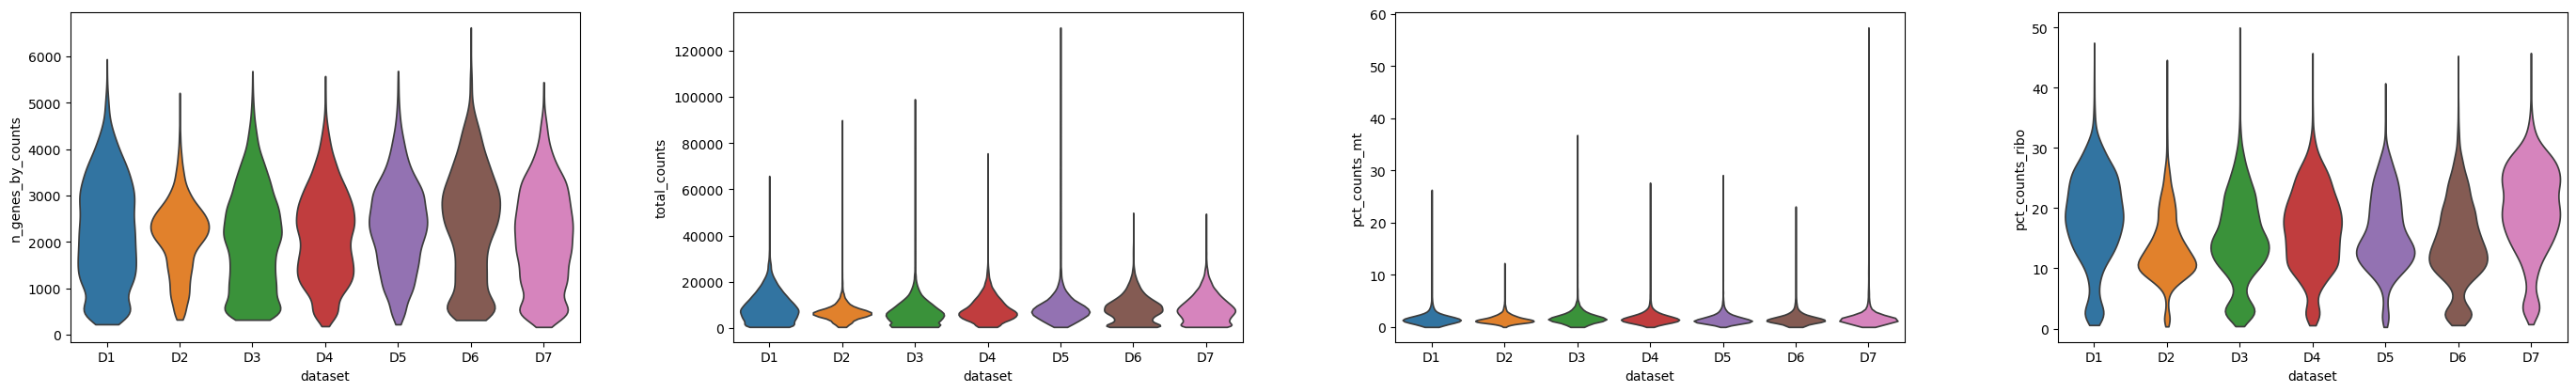

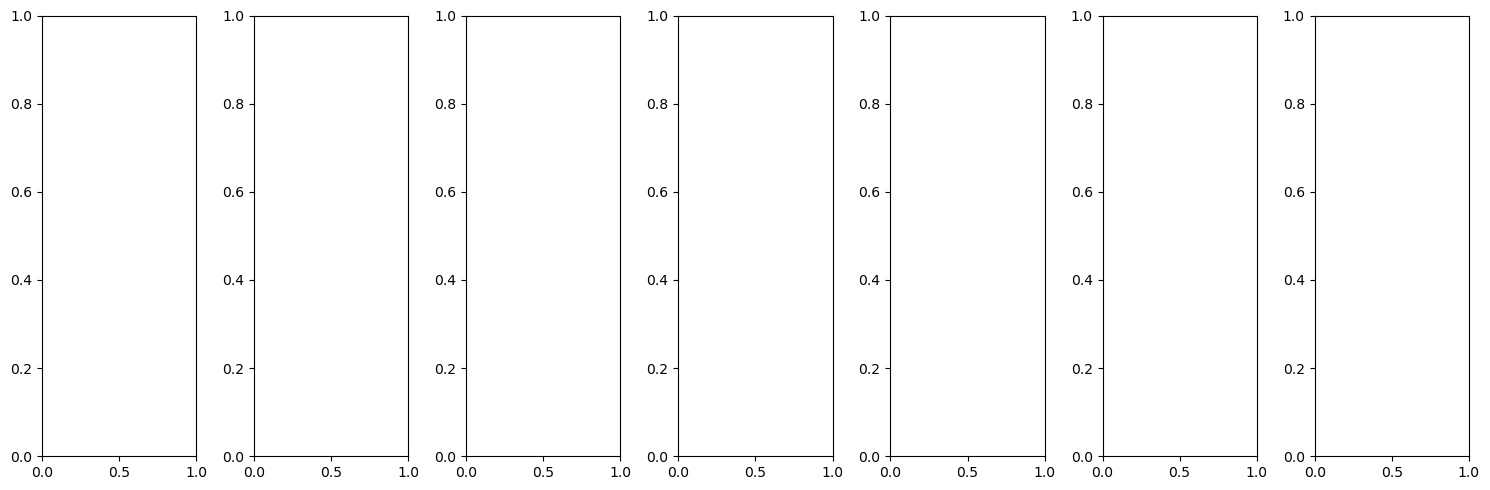

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

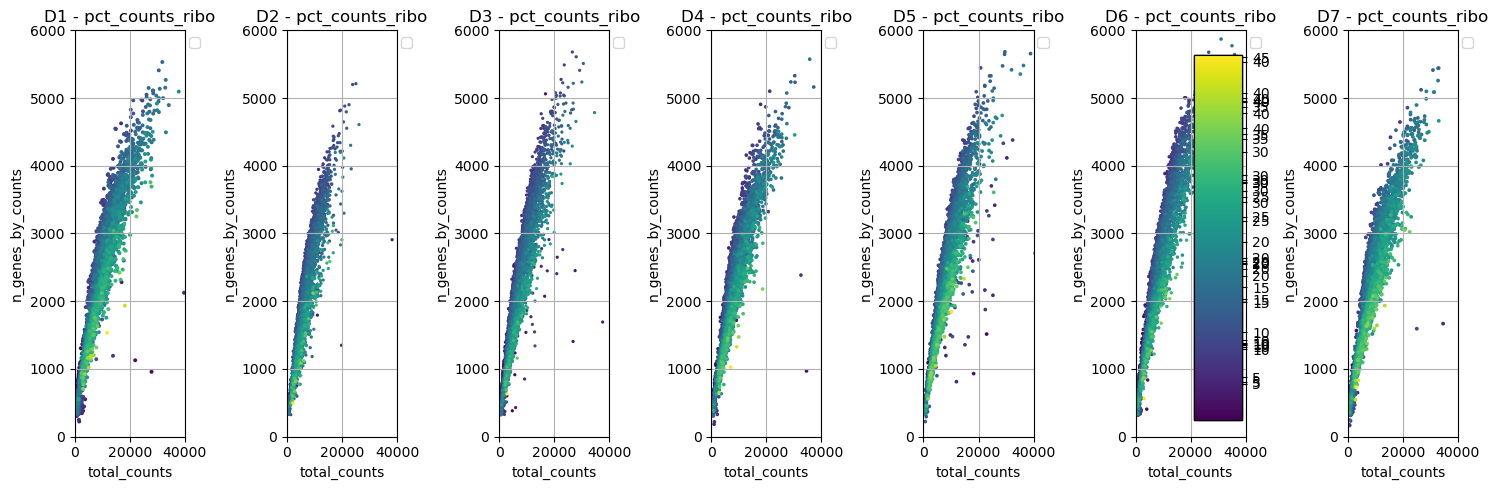

In [10]:
# Visualize pre-filtering QC measures
f.visualize_QC_measures(adatas)

## QC filtering 

Here we use the filtering function to filter cells and genes based on most basic parameters. for cells we will use a max mitochondrial gene read % of 5(explained in literature) and a minimum ribosomal gene expression of 5%. minimum count per cell of 1000, cell ranger itself has a minimum of 500, however we up the minimum which mostly gets rid of this population of very low-quality/odd cells. need to discuss with Yiyi if she agrees, but it does help. minimum gene count of 300. for genes we filter all that are not in atleast 3 cells. 

after filtering we visualize again so they can be compared.

*note: want to make a function to do median deviation thresholding, see how it compares

In [11]:
# Basic QC thresholds
QC_filtered_adatas = {}
for adata_key, adata in adatas.items():
    print(f"{adata_key}:")
    QC_filtered_adatas[adata_key] =f.QC_filter_adata(adata, mt_threshold=5, ribo_threshold=5, min_counts=2000, min_genes=300, min_cells=3)
    print("\n")

D1:
Initial AnnData has 3723 cells and 33993 genes
87 of 3723 cells contain more than 5% mitochondrial genes. Will be filtered
281 of 3723 cells contain less than 5% ribosomal genes. Will be filtered
221 of 3402 cells have fewer than 2000 counts. Will be filtered


/Users/loganlarlham/miniforge3/envs/scvi-env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_counts"] = number


0 of 3181 cells have fewer than 300 genes. Will be filtered
18826 of 33993 genes are expressed in fewer than 3 cells. Will be filtered
Filtered AnnData has 3181 cells and 15167 genes


D2:
Initial AnnData has 5399 cells and 33993 genes
30 of 5399 cells contain more than 5% mitochondrial genes. Will be filtered
182 of 5399 cells contain less than 5% ribosomal genes. Will be filtered
132 of 5201 cells have fewer than 2000 counts. Will be filtered
0 of 5069 cells have fewer than 300 genes. Will be filtered


/Users/loganlarlham/miniforge3/envs/scvi-env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_counts"] = number


18328 of 33993 genes are expressed in fewer than 3 cells. Will be filtered
Filtered AnnData has 5069 cells and 15665 genes


D3:
Initial AnnData has 5584 cells and 33993 genes
96 of 5584 cells contain more than 5% mitochondrial genes. Will be filtered
720 of 5584 cells contain less than 5% ribosomal genes. Will be filtered
219 of 4824 cells have fewer than 2000 counts. Will be filtered
0 of 4605 cells have fewer than 300 genes. Will be filtered


/Users/loganlarlham/miniforge3/envs/scvi-env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_counts"] = number


18296 of 33993 genes are expressed in fewer than 3 cells. Will be filtered
Filtered AnnData has 4605 cells and 15697 genes


D4:
Initial AnnData has 4315 cells and 33993 genes
107 of 4315 cells contain more than 5% mitochondrial genes. Will be filtered
224 of 4315 cells contain less than 5% ribosomal genes. Will be filtered
126 of 4041 cells have fewer than 2000 counts. Will be filtered
0 of 3915 cells have fewer than 300 genes. Will be filtered
18763 of 33993 genes are expressed in fewer than 3 cells. Will be filtered


/Users/loganlarlham/miniforge3/envs/scvi-env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_counts"] = number


Filtered AnnData has 3915 cells and 15230 genes


D5:
Initial AnnData has 4159 cells and 33993 genes
50 of 4159 cells contain more than 5% mitochondrial genes. Will be filtered
143 of 4159 cells contain less than 5% ribosomal genes. Will be filtered
103 of 3990 cells have fewer than 2000 counts. Will be filtered
0 of 3887 cells have fewer than 300 genes. Will be filtered
18534 of 33993 genes are expressed in fewer than 3 cells. Will be filtered


/Users/loganlarlham/miniforge3/envs/scvi-env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_counts"] = number


Filtered AnnData has 3887 cells and 15459 genes


D6:
Initial AnnData has 4757 cells and 33993 genes
78 of 4757 cells contain more than 5% mitochondrial genes. Will be filtered
556 of 4757 cells contain less than 5% ribosomal genes. Will be filtered
247 of 4163 cells have fewer than 2000 counts. Will be filtered
0 of 3916 cells have fewer than 300 genes. Will be filtered


/Users/loganlarlham/miniforge3/envs/scvi-env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_counts"] = number


18018 of 33993 genes are expressed in fewer than 3 cells. Will be filtered
Filtered AnnData has 3916 cells and 15975 genes


D7:
Initial AnnData has 4010 cells and 33993 genes
122 of 4010 cells contain more than 5% mitochondrial genes. Will be filtered
230 of 4010 cells contain less than 5% ribosomal genes. Will be filtered
320 of 3697 cells have fewer than 2000 counts. Will be filtered
0 of 3377 cells have fewer than 300 genes. Will be filtered
18857 of 33993 genes are expressed in fewer than 3 cells. Will be filtered


/Users/loganlarlham/miniforge3/envs/scvi-env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_counts"] = number


Filtered AnnData has 3377 cells and 15136 genes




Visualizations QC Measures for multiple datasets:


/Users/loganlarlham/Documents/Summer_proj_2024/Notebooks/func_lib.py:150: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  combined_data = adata[list(adata.keys())[0]].concatenate(*[adata[key] for key in list(adata.keys())[1:]], batch_key="dataset", batch_categories=list(adata.keys()))


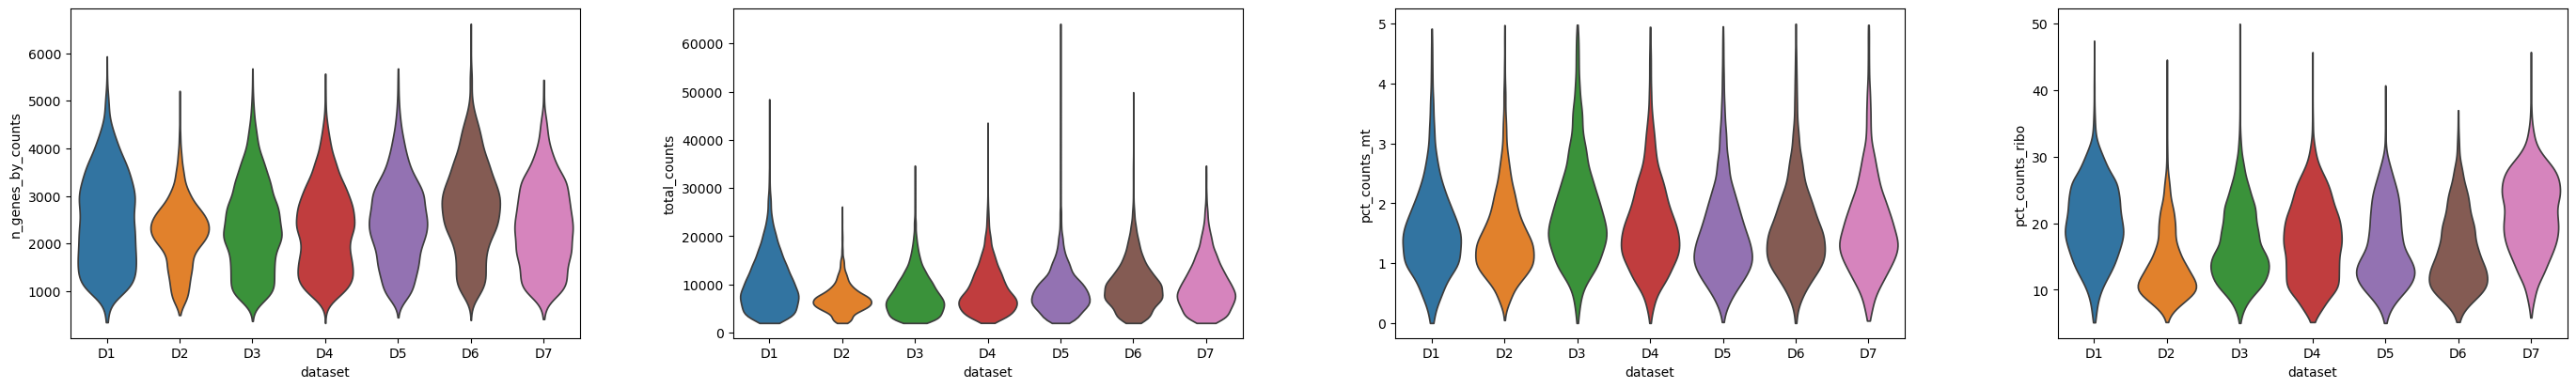

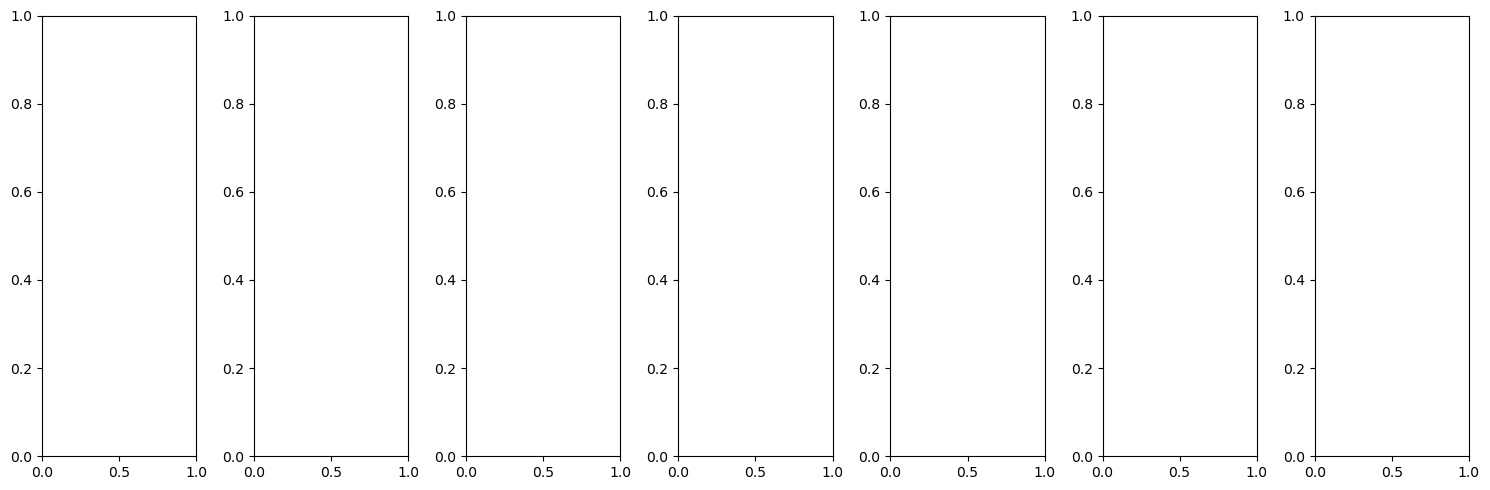

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

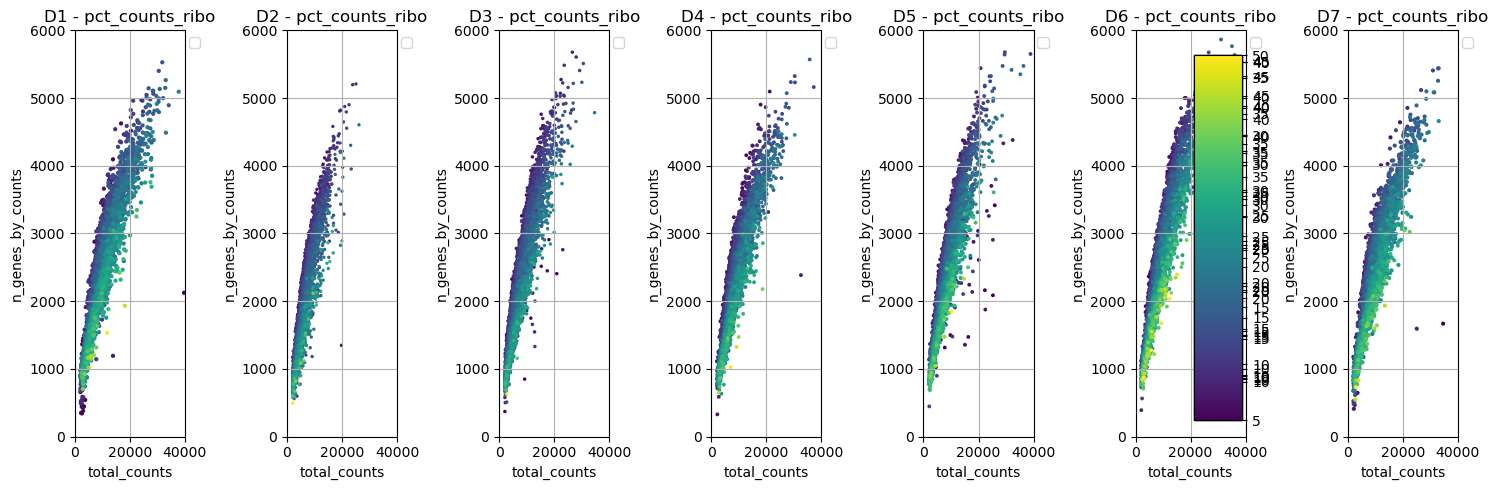

In [12]:
f.visualize_QC_measures(QC_filtered_adatas)

## Demultiplex hashtag

Using hash_demultiplex (calls hashsolo) function we associate each cell with the individual it was sampled from so we can know the genotype/treatment status of each cell. Based on hashtag counts will classify some cells as doublets and some as negative(empty). THese will be ignored for downstream analysis. they are kept in the dataset, but perhaps should consider just removing them here.

In [13]:
#Demultiplex hashtags from datasets
for adata_key, adata in QC_filtered_adatas.items():
    print(f"{adata_key}:")
    f.hash_demulitplex(adata)
    print("\n")

D1:
Number of predicted singlets: 2997
Number of predicted doublets: 180
Number of predicted negatives: 4
Number of cells for each hashtag:
K234: 842
K219: 765
K231: 715
K233: 675
Doublet: 180
Negative: 4


D2:
Number of predicted singlets: 4844
Number of predicted doublets: 224
Number of predicted negatives: 1
Number of cells for each hashtag:
G180: 1244
G146: 1214
G143: 1203
K232: 1183
Doublet: 224
Negative: 1


D3:
Number of predicted singlets: 4283
Number of predicted doublets: 321
Number of predicted negatives: 1
Number of cells for each hashtag:
K262: 1208
K261: 1171
K257: 1095
K268: 809
Doublet: 321
Negative: 1


D4:
Number of predicted singlets: 3650
Number of predicted doublets: 265
Number of predicted negatives: 0
Number of cells for each hashtag:
G122: 1051
G119: 900
G120: 850
G118: 849
Doublet: 265


D5:
Number of predicted singlets: 3642
Number of predicted doublets: 244
Number of predicted negatives: 1
Number of cells for each hashtag:
G184: 1043
G183: 953
G185: 944
G186:

Remove all cells marked as doublet or negative from dataset, not useful. 

In [14]:
#remove doublets and empty droplets from datasets 
for adata_key, adata in QC_filtered_adatas.items():
    print(f"Removing doublets and empty droplets from {adata_key}:")
    print(f"number of cells before: {adata.obs.shape[0]}")
    doublets = adata.obs['most_likely_hypothesis'] == 2
    negatives = adata.obs['most_likely_hypothesis'] == 0
    adata = adata[~doublets & ~negatives]
    QC_filtered_adatas[adata_key] = adata
    print(f"number of cells after: {adata.obs.shape[0]}")
    print("\n")

Removing doublets and empty droplets from D1:
number of cells before: 3181
number of cells after: 2997


Removing doublets and empty droplets from D2:
number of cells before: 5069
number of cells after: 4844


Removing doublets and empty droplets from D3:
number of cells before: 4605
number of cells after: 4283


Removing doublets and empty droplets from D4:
number of cells before: 3915
number of cells after: 3650


Removing doublets and empty droplets from D5:
number of cells before: 3887
number of cells after: 3642


Removing doublets and empty droplets from D6:
number of cells before: 3916
number of cells after: 3712


Removing doublets and empty droplets from D7:
number of cells before: 3377
number of cells after: 3181




## Data Merge

Next we merge all the datasets into one

In [15]:
for adata_key, adata in QC_filtered_adatas.items():
    print(f"dataset {adata_key}:")
    for index, row in adata.var.iterrows():
        if row['feature_types'] == 'Antibody Capture':
            print(f"gene_ids: {row['gene_ids']}, Name: {index}")



dataset D1:
gene_ids: Hashtag_1, Name: K231
gene_ids: Hashtag_2, Name: K233
gene_ids: Hashtag_3, Name: K234
gene_ids: Hashtag_4, Name: K219
dataset D2:
gene_ids: Hashtag_1, Name: G143
gene_ids: Hashtag_2, Name: G146
gene_ids: Hashtag_3, Name: K232
gene_ids: Hashtag_4, Name: G180
dataset D3:
gene_ids: Hashtag_1, Name: K257
gene_ids: Hashtag_2, Name: K261
gene_ids: Hashtag_3, Name: K262
gene_ids: Hashtag_4, Name: K268
dataset D4:
gene_ids: Hashtag_1, Name: G118
gene_ids: Hashtag_2, Name: G119
gene_ids: Hashtag_3, Name: G120
gene_ids: Hashtag_4, Name: G122
dataset D5:
gene_ids: Hashtag_1, Name: G183
gene_ids: Hashtag_2, Name: G184
gene_ids: Hashtag_3, Name: G185
gene_ids: Hashtag_4, Name: G186
dataset D6:
gene_ids: Hashtag_1, Name: K248
gene_ids: Hashtag_2, Name: K249
gene_ids: Hashtag_3, Name: K250
gene_ids: Hashtag_4, Name: K252
dataset D7:
gene_ids: Hashtag_1, Name: G177
gene_ids: Hashtag_2, Name: G178
gene_ids: Hashtag_3, Name: G179
gene_ids: Hashtag_4, Name: G145


In [16]:
# Function to align .var columns and print misaligned columns
def align_var_columns(adatas):
    # Get the union of all column names
    all_columns = set()
    for adata in adatas.values():
        all_columns.update(adata.var.columns)

    # Align columns for each dataset and print misaligned columns
    for adata_key, adata in adatas.items():
        misaligned_columns = [col for col in all_columns if col not in adata.var.columns]
        if misaligned_columns:
            print(f"{adata_key} is missing columns: {misaligned_columns}")
        for col in misaligned_columns:
            adata.var[col] = None  # or some appropriate default value
        # Ensure columns are in the same order
        adata.var = adata.var[list(all_columns)]

# Example usage with your datasets
align_var_columns(QC_filtered_adatas)


In [17]:
genotype_map = {"K191" : "E3FAD", "K192" : "E3FAD", "K190" : "E3WT", "K193" : "E3WT", 
                "G118" : "E4FAD", "G119" : "E4FAD", "G120" : "E4FAD", "G122" : "E4WT",
                "K231" : "E3FAD", "K233" : "E3FAD", "K234" : "E3FAD", "K219" : "E4FAD",
                "G143" : "E4WT", "G146" : "E4WT", "K232" : "E3WT", "G180" : "E4WT", 
                "G183" : "E4WT", "G184" : "E4WT", "G185" : "E4WT", "G186" : "E4FAD",
                "K248" : "E3WT", "K249" : "E3WT", "K250" : "E3FAD", "K252" : "E3FAD", 
                "G177" : "E4FAD", "G178" : "E4FAD", "G179" : "E4FAD", "G145" : "E4FAD",
                "K257" : "E3WT", "K261" : "E3WT", "K262" : "E3WT", "K268" : "E3FAD",
                "K283" : "E3WT", "K284" : "E3FAD"}
treatment_map = {"K191" : "LPS", "K192" : "LPS", "K190" : "LPS", "K193" : "LPS", 
                "G118" : "VEHICLE", "G119" : "VEHICLE", "G120" : "VEHICLE", "G122" : "VEHICLE",
                "K231" : "VEHICLE", "K233" : "VEHICLE", "K234" : "VEHICLE", "K219" : "LPS",
                "G143" : "LPS", "G146" : "LPS", "K232" : "VEHICLE", "G180" : "LPS", 
                "G183" : "VEHICLE", "G184" : "VEHICLE", "G185" : "VEHICLE", "G186" : "VEHICLE",
                "K248" : "LPS", "K249" : "LPS", "K250" : "LPS", "K252" : "LPS", 
                "G177" : "LPS", "G178" : "LPS", "G179" : "LPS", "G145" : "LPS",
                "K257" : "VEHICLE", "K261" : "VEHICLE", "K262" : "VEHICLE", "K268" : "VEHICLE",
                "K283" : "LPS", "K284" : "LPS"}


adata = ad.concat(list(QC_filtered_adatas.values()), axis=0, label="sample", join="outer", merge="unique")

#make adata.obs unique
adata.obs.index = adata.obs.index + "_" + adata.obs["sample"].astype(str)

adata.obs["genotype"] = adata.obs["Classification"].map(lambda x: genotype_map.get(x, None))

# Mapping for apoe (first two characters of the genotype value)
adata.obs["apoe"] = adata.obs["Classification"].map(lambda x: genotype_map.get(x, None)[:2] if genotype_map.get(x, None) else None)

# Mapping for disease (characters after the first two characters of the genotype value)
adata.obs["disease"] = adata.obs["Classification"].map(lambda x: genotype_map.get(x, None)[2:] if genotype_map.get(x, None) else None)
adata.obs["treatment"] = adata.obs["Classification"].map(lambda x: treatment_map.get(x, None))

#print number of samples of each genotype, treatment, and combination of genotype and treatment
print("Number of cells of each genotype:")
print(adata.obs["genotype"].value_counts())
print("\n")
print("Number of cells of each treatment:")
print(adata.obs["treatment"].value_counts())
print("\n")
print("Number of cells of each genotype and treatment:")
print(adata.obs.groupby(["genotype", "treatment"]).size())
print("\n")
print(adata.obs.groupby(["Classification", "genotype"]).size().sort_values(ascending=False))


Number of cells of each genotype:
genotype
E4WT     7652
E4FAD    7247
E3WT     6825
E3FAD    4585
Name: count, dtype: int64


Number of cells of each treatment:
treatment
VEHICLE    14990
LPS        11319
Name: count, dtype: int64


Number of cells of each genotype and treatment:
genotype  treatment
E3FAD     LPS          1544
          VEHICLE      3041
E3WT      LPS          2168
          VEHICLE      4657
E4FAD     LPS          3946
          VEHICLE      3301
E4WT      LPS          3661
          VEHICLE      3991
dtype: int64


Classification  genotype
G180            E4WT        1244
G146            E4WT        1214
K262            E3WT        1208
G143            E4WT        1203
K232            E3WT        1183
K261            E3WT        1171
K248            E3WT        1128
K257            E3WT        1095
G122            E4WT        1051
G184            E4WT        1043
K249            E3WT        1040
G183            E4WT         953
G185            E4WT         944
G119 

/Users/loganlarlham/miniforge3/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [18]:
grouped_data = adata.obs.groupby(["sample", "Classification", "disease", "apoe", "treatment"]).size().sort_values(ascending=False)
grouped_data = grouped_data[grouped_data > 0]
print(grouped_data.to_string())

sample  Classification  disease  apoe  treatment
1       G180            WT       E4    LPS          1244
        G146            WT       E4    LPS          1214
2       K262            WT       E3    VEHICLE      1208
1       G143            WT       E4    LPS          1203
        K232            WT       E3    VEHICLE      1183
2       K261            WT       E3    VEHICLE      1171
5       K248            WT       E3    LPS          1128
2       K257            WT       E3    VEHICLE      1095
3       G122            WT       E4    VEHICLE      1051
4       G184            WT       E4    VEHICLE      1043
5       K249            WT       E3    LPS          1040
4       G183            WT       E4    VEHICLE       953
        G185            WT       E4    VEHICLE       944
3       G119            FAD      E4    VEHICLE       900
5       K252            FAD      E3    LPS           871
6       G177            FAD      E4    LPS           855
3       G120            FAD      E4    

/var/folders/n8/l_thwp511tqdnvx3xvmjy3y80000gn/T/ipykernel_57261/2017754753.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = adata.obs.groupby(["sample", "Classification", "disease", "apoe", "treatment"]).size().sort_values(ascending=False)


In [19]:
group_sizes = adata.obs.groupby(["Classification", "disease"]).size().reset_index(name='size')

# Step 2: Group by 'disease' and calculate the mean size for each classification within each disease group
mean_sizes = group_sizes.groupby("disease")["size"].mean().reset_index()

print(mean_sizes)

  disease         size
0     FAD   788.800000
1      WT  1113.615385


In [20]:
print(adata.X.toarray().max())

31619.0


In [21]:
# Check if 'G118' is in the .var DataFrame after concatenation
for hashtag in genotype_map.keys():
    if hashtag in adata.var_names:
        print(f"{hashtag} is present in the .var DataFrame.")
    else:
        print(f"{hashtag} is not present in the .var DataFrame.")

K191 is not present in the .var DataFrame.
K192 is not present in the .var DataFrame.
K190 is not present in the .var DataFrame.
K193 is not present in the .var DataFrame.
G118 is present in the .var DataFrame.
G119 is present in the .var DataFrame.
G120 is present in the .var DataFrame.
G122 is present in the .var DataFrame.
K231 is present in the .var DataFrame.
K233 is present in the .var DataFrame.
K234 is present in the .var DataFrame.
K219 is present in the .var DataFrame.
G143 is present in the .var DataFrame.
G146 is present in the .var DataFrame.
K232 is present in the .var DataFrame.
G180 is present in the .var DataFrame.
G183 is present in the .var DataFrame.
G184 is present in the .var DataFrame.
G185 is present in the .var DataFrame.
G186 is present in the .var DataFrame.
K248 is present in the .var DataFrame.
K249 is present in the .var DataFrame.
K250 is present in the .var DataFrame.
K252 is present in the .var DataFrame.
G177 is present in the .var DataFrame.
G178 is p

In [22]:
# remove hashtag genes

hashtag_genes = [gene for gene in adata.var_names if any(ht in gene for ht in genotype_map.keys())]
adata = adata[:, ~adata.var_names.isin(hashtag_genes)]

# Check if hashtag is in the .var DataFrame after concatenation
for hashtag in genotype_map.keys():
    if hashtag in adata.var_names:
        print(f"{hashtag} is present in the .var DataFrame.")
    else:
        print(f"{hashtag} is not present in the .var DataFrame.")

K191 is not present in the .var DataFrame.
K192 is not present in the .var DataFrame.
K190 is not present in the .var DataFrame.
K193 is not present in the .var DataFrame.
G118 is not present in the .var DataFrame.
G119 is not present in the .var DataFrame.
G120 is not present in the .var DataFrame.
G122 is not present in the .var DataFrame.
K231 is not present in the .var DataFrame.
K233 is not present in the .var DataFrame.
K234 is not present in the .var DataFrame.
K219 is not present in the .var DataFrame.
G143 is not present in the .var DataFrame.
G146 is not present in the .var DataFrame.
K232 is not present in the .var DataFrame.
G180 is not present in the .var DataFrame.
G183 is not present in the .var DataFrame.
G184 is not present in the .var DataFrame.
G185 is not present in the .var DataFrame.
G186 is not present in the .var DataFrame.
K248 is not present in the .var DataFrame.
K249 is not present in the .var DataFrame.
K250 is not present in the .var DataFrame.
K252 is not

## Normalization and Feature selection

In this section we will make a adata layer which contains log1p normalized  counts which will be used for certain steps. also detect highly variable genes using scanpy function

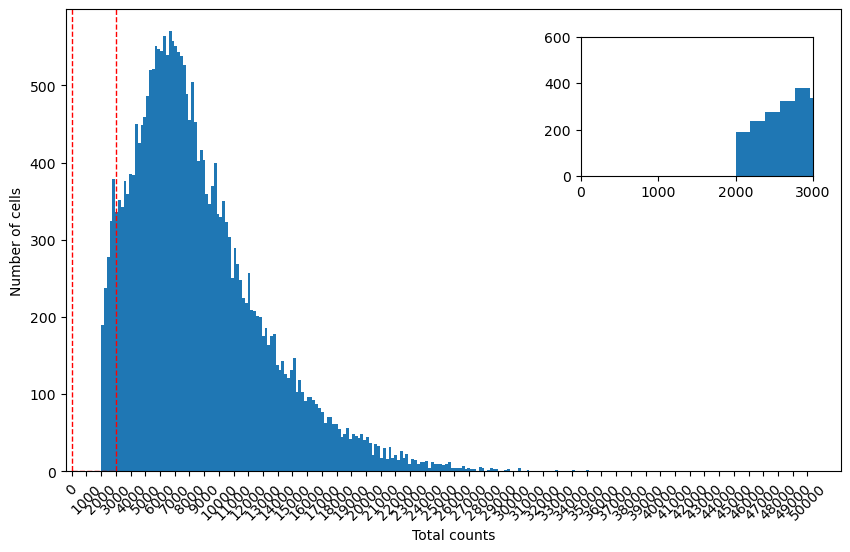

In [23]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Assuming adata is already defined and loaded

# Main plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(adata.obs["total_counts"], bins=250, log=False, label="Total counts in bins of 100")
ax.set_xlabel("Total counts")
ax.set_ylabel("Number of cells")
ax.set_xticks(range(0, int(adata.obs["total_counts"].max()) + 1000, 1000))
plt.xticks(rotation=45)

# Create inset of the zoomed area
axins = inset_axes(ax, width="30%", height="30%", loc="upper right", borderpad=2)
axins.hist(adata.obs["total_counts"], bins=250, log=False)

# Zoom in on the inset
x1, x2, y1, y2 = 0, 3000, 0, 600  # Adjust these values as needed
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)


# Add a rectangle to highlight the zoomed area in the main plot
rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, edgecolor='r', facecolor='none', linestyle='--')
ax.add_patch(rect)

plt.show()

2480.0

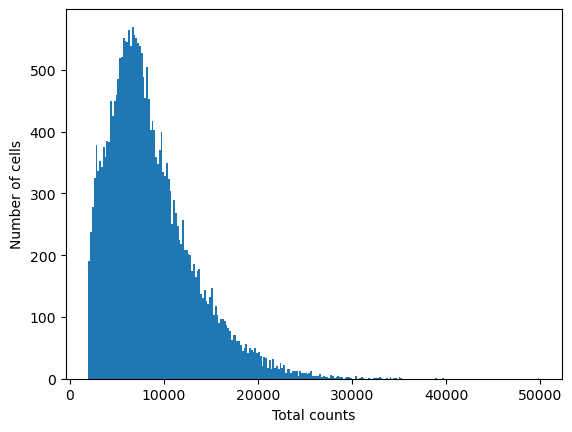

In [24]:
# plot raw UMI counts per cell in histogram 

plt.hist(adata.obs["total_counts"], bins=250, log=False, label="Total counts in bins of 100")
plt.xlabel("Total counts")
plt.ylabel("Number of cells")
adata.X.toarray().max()


In [25]:
# save raw counts as layer in adata for future use

In [26]:
adata.layers["counts"] = adata.X.copy()

/var/folders/n8/l_thwp511tqdnvx3xvmjy3y80000gn/T/ipykernel_57261/1517723426.py:1: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers["counts"] = adata.X.copy()


In [27]:
adata.X = adata.layers["counts"].copy()
adata.X.toarray().max()

2480.0

7.610413

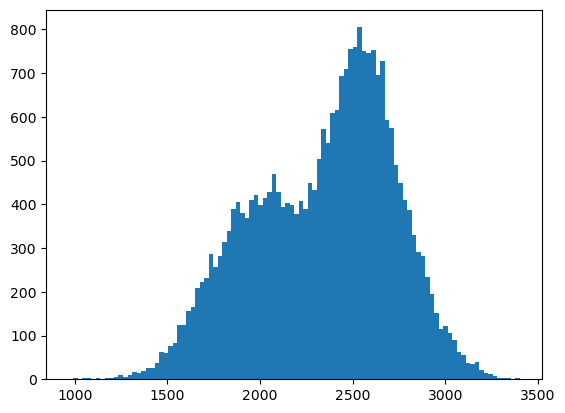

In [28]:
# normalize and log the data and store that in a different layer too incase we need to switch between them.
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.layers['log_norm'] = adata.X.copy()
#so we can plot a histogram of the total counts/cells after norm
adata.obs["norm_total_counts"] = adata.X.sum(axis=1)
plt.hist(adata.obs["norm_total_counts"], bins=100, log=False, label="normed total counts in bins of 100")
adata.X.toarray().max()

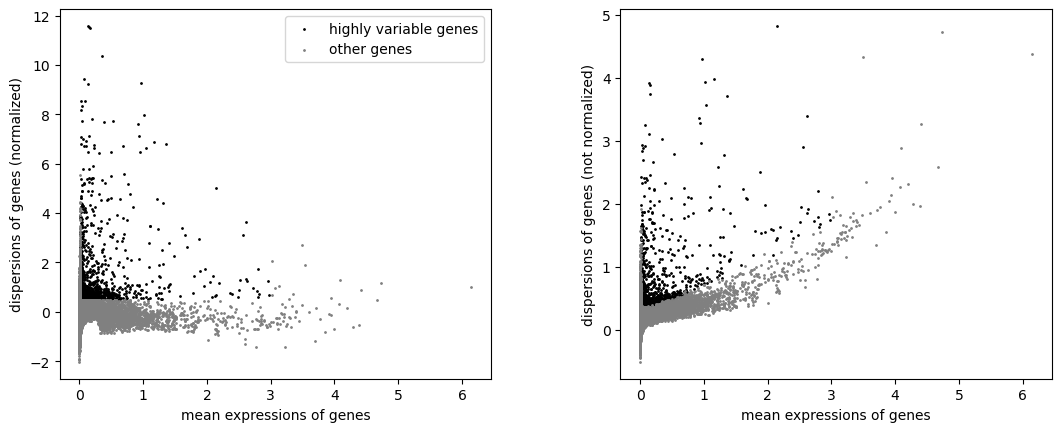

1133 out of 17352 genes are considered highly variable.


In [29]:
sc.pp.highly_variable_genes(adata, batch_key="sample")
sc.pl.highly_variable_genes(adata)
#make some variables to print a nice little summary
num_highly_variable_genes_t = adata.var['highly_variable'].sum()
total_genes_t = adata.var.shape[0]

print(f"{num_highly_variable_genes_t} out of {total_genes_t} genes are considered highly variable.")

In [30]:
#reset adata.X to the raw counts
adata.X = adata.layers['counts'].copy()

#check to see if the raw counts are still there
adata.X.toarray().max()

2480.0

## Save adata object

Finally we save the adata object for use in the next notebooks, batch correction and Analysis. 

In summary this Adata object contains all the datasets merged into one object and:
- hashtag genes removed
- the dataset they came from annotated under .obs['sample']
- the disease-state FAD or WT saved in .obs['disease']
- the apoe isoform, E3 or E4, saved in .obs['apoe']
- the treatment, LPS or VEH saved in .obs['treatment']
and the complete genotype E3WT, E4WT, E3FAD, E4FAD, in .obs['genotype']
- two layers .layer['counts'] containing raw and ['log_norm'] with normed
- basic QC metrics. 

In [31]:
# save adata to file for future use
adata.write("QC_merge_output_adata.h5ad")